# Service types provision assessment

In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

In [2]:
from blocksnet.models import City
city_model = City.from_pickle(os.path.join(example_data_path, 'city_model123.pickle'))

In [3]:
city_model.service_types

[ServiceType(name='kindergartens', accessibility=10, demand=61),
 ServiceType(name='schools', accessibility=15, demand=120),
 ServiceType(name='recreational_areas', accessibility=15, demand=6000),
 ServiceType(name='hospitals', accessibility=60, demand=9),
 ServiceType(name='pharmacies', accessibility=10, demand=50),
 ServiceType(name='policlinics', accessibility=15, demand=27)]

In [4]:
from blocksnet.method import Provision
prov = Provision(city_model=city_model)

<Axes: title={'center': 'Provision:  0.541'}>

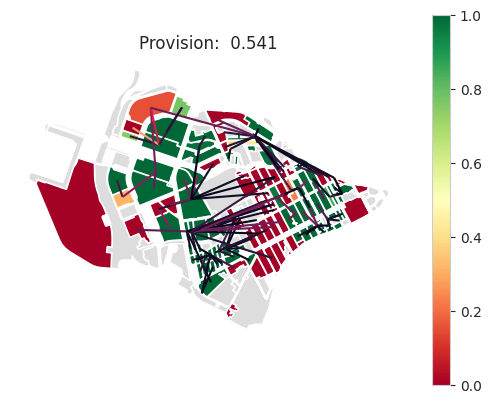

In [15]:
calc_before, weights_before = prov.calculate('kindergartens', method='lp')
ax = prov.plot(calc_before)
weights_gdf = prov.weights_to_gdf(weights_before)
weights_gdf.plot(column='weight', ax=ax)

In [6]:
import pandas as pd

update = {
  148: {
    'population': 10000,
  }
}

update_df = pd.DataFrame.from_dict(update, orient='index')

<Axes: title={'center': 'Provision:  0.517'}>

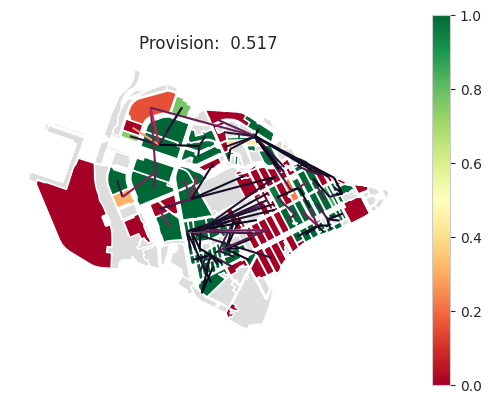

In [7]:
calc_after, weights_after = prov.calculate('kindergartens', update_df=update_df, method='lp')
ax = prov.plot(calc_after)
weights_gdf = prov.weights_to_gdf(weights_after)
weights_gdf.plot(column='weight', ax=ax)

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


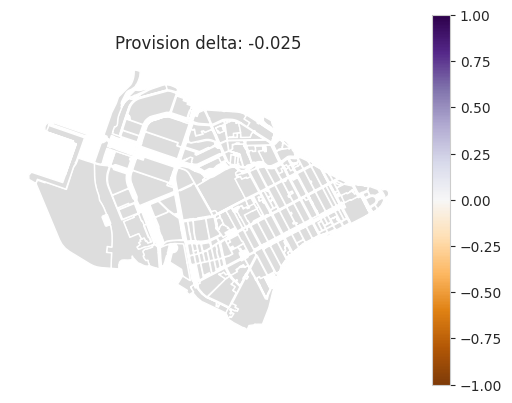

In [8]:
prov.plot_delta(calc_before, calc_after)

In [9]:
Provision.stat_provision(calc_before)

{'mean': 0.5907211588269762, 'median': 1.0, 'min': 0.0, 'max': 1.0}

In [10]:
Provision.stat_provision(calc_after)

{'mean': 0.5907211588269762, 'median': 1.0, 'min': 0.0, 'max': 1.0}

In [11]:
scenario = {'schools': 0.5, 'kindergartens': 0.5}
gdf, total = prov.calculate_scenario(scenario)
print(total)

0.6709120101908853
